In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras import backend as K
#from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense,GlobalAveragePooling2D,Dropout,SeparableConv2D,BatchNormalization, Activation, Dense
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet101
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Lambda, Dense, Flatten
import matplotlib.pyplot as plt

# dataset has 3 classes
num_class = 2

# Base model without Fully connected Layers
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(224,224,3))

# don't train existing weights
for layer in base_model.layers:
  layer.trainable = False
  
  
x=base_model.output
x = Flatten()(base_model.output)
##3 classes ,COVID, PNEUNOMIA, NORMAL


preds=Dense(num_class, activation='softmax')(x) #final layer with softmax activation

model=Model(inputs=base_model.input,outputs=preds)
##check the model
model.summary()


# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


##Preparing Data 
train_datagen=ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input,
                                 validation_split=0.25)

train_generator=train_datagen.flow_from_directory(r"C:\Users\Computing\Downloads\data-task1\data-task1\train",
                                                 target_size=(224,224),
                                                 batch_size=64,
                                                 class_mode='categorical',
                                                 subset='training')


validation_generator = train_datagen.flow_from_directory(r"C:\Users\Computing\Downloads\data-task1\data-task1\val", # same directory as training data
                                                target_size=(224,224),
                                                batch_size=64,
                                                class_mode='categorical',
                                                subset='validation') # set as validation data



##Training
##SEtting hyper parameter
epochs = 50
learning_rate = 0.0005
decay_rate = learning_rate / epochs
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, decay=decay_rate, amsgrad=False)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])


##Train
step_size_train = train_generator.n/train_generator.batch_size
step_size_val = validation_generator.samples // validation_generator.batch_size
r = model.fit_generator(generator=train_generator,
                   steps_per_epoch=step_size_train,
                   validation_data = validation_generator, 
                   validation_steps =step_size_val,
                   epochs=5)


##Confusion Matrix  (Sample code for confusion matrix but this is not working, it doesn't produce error neither results)
from sklearn.metrics import classification_report, confusion_matrix
batch_size=64
Y_pred = model.predict_generator(validation_generator,186)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['NORMAL','PNEUMONIA']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

80150528/80134624 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
<ipython-input-1-a96c31f257e2>:78: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  r = model.fit_generator(generator=train_generator,


Epoch 1/5
35/35 [==============================] - 192s 5s/step - loss: 5.1403 - accuracy: 0.7521 - val_loss: 2.4597 - val_accuracy: 0.7812
Epoch 2/5
35/35 [==============================] - 219s 6s/step - loss: 1.3101 - accuracy: 0.8281 - val_loss: 2.5222 - val_accuracy: 0.8125
Epoch 3/5
35/35 [==============================] - 220s 6s/step - loss: 0.3915 - accuracy: 0.9165 - val_loss: 2.5613 - val_accuracy: 0.8125
Epoch 4/5
35/35 [==============================] - 219s 6s/step - loss: 0.1345 - accuracy: 0.9596 - val_loss: 2.4915 - val_accuracy: 0.7188
Epoch 5/5
35/35 [==============================] - 221s 6s/step - loss: 0.0623 - accuracy: 0.9809 - val_loss: 1.9704 - val_accuracy: 0.7969


<ipython-input-1-a96c31f257e2>:88: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator(validation_generator,186)


Confusion Matrix
[[89  8]
 [21  6]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.81      0.92      0.86        97
   PNEUMONIA       0.43      0.22      0.29        27

    accuracy                           0.77       124
   macro avg       0.62      0.57      0.58       124
weighted avg       0.73      0.77      0.74       124



In [2]:
cm=confusion_matrix(validation_generator.classes, y_pred)

[Text(0, 0.5, 'Pneumonia'), Text(0, 1.5, 'no_pneumonia')]

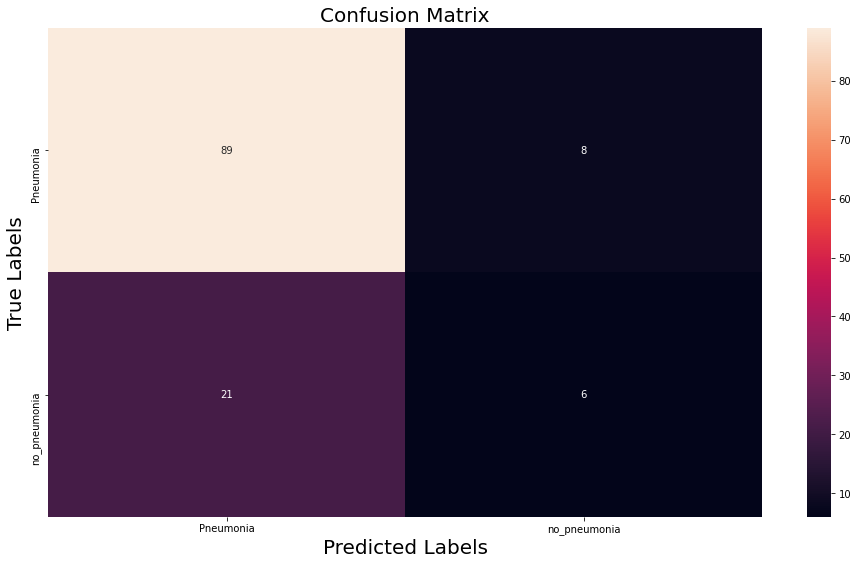

In [6]:
import seaborn as sns 
matrix = confusion_matrix(validation_generator.classes, y_pred)
labels=(( 'Pneumonia'),('no_pneumonia'))
plt.figure(figsize=(16, 9))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


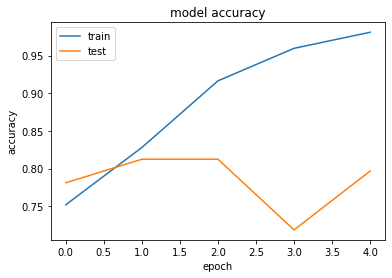

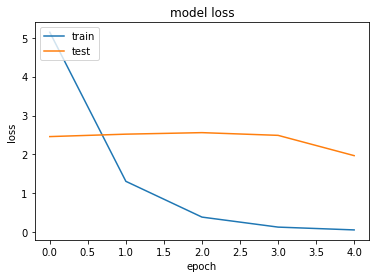

In [12]:
print(r.history.keys())
# summarize history for accuracy
plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
